# Spectral normalization GAN with categorical projection conditioning
*Thomas Viehmann <tv@lernapparat.de>*

# This is work in progress, i.e. it probably doesn't work

Spectral Normalization GANs are an exiting new regularization method that approximates the Wasserstein loss as a discriminator function. The authors also demonstrated the capabilities of a projection method for the discriminator - generating images for all 1000 imagenet (LSVRC2012) categories. We implement the smaller 64x64 pixel variant.
One of the crucial ingredients on the side of the Generator is a Conditional Batch Norm that enables learning a class-specific multiplier and bias.

This repository
- is a straightforward adaptation of the [official chainer-based implementation in the 64x64 case](https://github.com/pfnet-research/sngan_projection)
- PyTorch's [spectral_norm](https://pytorch.org/docs/master/nn.html#torch.nn.utils.spectral_norm) implementation
- a custom Conditional Batch Norm modelled after the above official implementation but in a PyTorch-style way (see below)
- Python 3 and PyTorch / master + [PR 9020](https://github.com/pytorch/pytorch/pull/9020)

First let's import something:

In [2]:
import torch
import torch.utils.data
import torchvision
import os
import matplotlib

try: # We want to have headless support after converting to .py
    %matplotlib inline
except:
    matplotlib.use('Agg')
from matplotlib import pyplot

import time

## Conditional Batch Norm

Here is the promised conditional batch norm. It aims to be compatible in functionality [to the SN-GAN author's version](https://github.com/pfnet-research/sngan_projection), the original reference seems to be [de Vries et. al., Modulating early visual processing by language](https://arxiv.org/abs/1707.00683).

It works pretty much like [regular batch norm](https://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm2d) *except* that it has a per-class weight $\gamma$ and bias $\beta$.
In particular, note that the input mean and variance (to be "cleaned") and the running statistics are *not* class dependent. (Of course, one might wonder whether it should, but that is for another day...)

There also is a conditional instance norm, (which would resolve the input that the statistics being generated accross classes during training, but not during evaluation).

In [3]:
class CategoricalConditionalBatchNorm(torch.nn.Module):
    # as in the chainer SN-GAN implementation , we keep per-cat XXX.
    # I should care more about accreal
    def __init__(self, num_features, num_cats, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.num_cats = num_cats
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.weight = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
            self.bias = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
        else:
            self.rsegister_parameter('weight', None)
            self.register_parameter('bias', None)
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.uniform_()
            self.bias.data.zero_()

    def _check_input_dim(self, input):
        raise NotImplementedError

    def forward(self, input, cats):
        #self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        n = input.size(0)
        numel_per_feature = input.numel()/input.size(1)
        if self.training or not self.track_running_stats:
            with torch.no_grad():
                m = input
                for d in range(input.dim()):
                    if d != 1:
                        m = m.mean(d, keepdim=True)
                v = (input-m).pow_(2)
                for d in range(input.dim()):
                    if d != 1:
                        v = v.mean(d, keepdim=True)
                unbiased_var_update = (v * (numel_per_feature / (numel_per_feature - 1.0))).squeeze_().mul_(exponential_average_factor)

                if self.track_running_stats:
                    self.running_var *= (1 - exponential_average_factor)
                    self.running_var += unbiased_var_update
                    self.running_mean *= (1 - exponential_average_factor)
                    self.running_mean += exponential_average_factor * m.squeeze()
        else:
            shape = [1, -1] + (input.dim() - 2) * [1]
            v = self.running_var.detach().view(shape)
            m = self.running_mean.detach().view(shape)
            

        x = (input - m) / (v + self.eps).sqrt_()
        
        if self.affine:
            shape = [n, -1] + (input.dim() - 2) * [1]
            weight = self.weight.index_select(0, cats).view(shape)
            bias = self.bias.index_select(0, cats).view(shape)
            x = x * weight + bias
        return x

    def extra_repr(self):
        return '{num_features}, num_cats={num_cats}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)



## Generator

With that, we can define the generator.

In [4]:

class ResGenBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, ksize=3, pad=1,
                 activation=torch.nn.functional.relu, upsample=False, n_classes=0):
        super().__init__()
        self.activation = activation
        self.upsample = upsample
        self.learnable_sc = in_channels != out_channels or upsample
        hidden_channels = out_channels if hidden_channels is None else hidden_channels
        self.n_classes = n_classes
        self.c1 = torch.nn.Conv2d(in_channels, hidden_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c1.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c1.bias)
        self.c2 = torch.nn.Conv2d(hidden_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c2.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c2.bias)
        if n_classes > 0:
            self.b1 = CategoricalConditionalBatchNorm(in_channels, n_classes)
            self.b2 = CategoricalConditionalBatchNorm(hidden_channels, n_classes)
        else:
            self.b1 = torch.nn.BatchNorm2d(in_channels)
            self.b2 = torch.nn.BatchNorm2d(hidden_channels)
        if self.learnable_sc:
            self.c_sc = torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
            torch.nn.init.xavier_uniform_(self.c_sc.weight)
            torch.nn.init.zeros_(self.c_sc.bias)

    def forward(self, x, y=None, DEBUG=None, debugname="ResGenBlock"):
        h = x
        if DEBUG is not None: DEBUG[debugname+'.inp'] = h.detach().cpu()
        h = self.b1(h, y) if y is not None else self.b1(h)
        if DEBUG is not None: DEBUG[debugname+'.b1'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a1'] = h.detach().cpu()
        if self.upsample:
            h = torch.nn.functional.upsample(h, scale_factor=2)
        h = self.c1(h)
        if DEBUG is not None: DEBUG[debugname+'.c1'] = h.detach().cpu()
        h = self.b2(h, y) if y is not None else self.b2(h)
        if DEBUG is not None: DEBUG[debugname+'.b2'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a2'] = h.detach().cpu()
        h = self.c2(h)
        if DEBUG is not None: DEBUG[debugname+'.c2'] = h.detach().cpu()
        if self.learnable_sc:
            if self.upsample:
                x = torch.nn.functional.upsample(x, scale_factor=2)
            sc = self.c_sc(x)
            if DEBUG is not None: DEBUG[debugname+'.sc'] = h.detach().cpu()
        else:
            sc = x
        return h + sc


class ResNetGenerator(torch.nn.Module):
    def __init__(self, ch=64, dim_z=128, bottom_width=4, activation=torch.nn.functional.relu, n_classes=0, distribution="normal"):
        super().__init__()
        self.bottom_width = bottom_width
        self.activation = activation
        self.distribution = distribution
        self.dim_z = dim_z
        self.n_classes = n_classes
        self.l1 = torch.nn.Linear(dim_z, (bottom_width ** 2) * ch * 16)
        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.zeros_(self.l1.bias)
        self.block2 = ResGenBlock(ch * 16, ch * 8, activation=activation, upsample=True, n_classes=n_classes)
        self.block3 = ResGenBlock(ch * 8, ch * 4, activation=activation, upsample=True, n_classes=n_classes)
        self.block4 = ResGenBlock(ch * 4, ch * 2, activation=activation, upsample=True, n_classes=n_classes)
        self.block5 = ResGenBlock(ch * 2, ch, activation=activation, upsample=True, n_classes=n_classes)
        self.b6 = torch.nn.BatchNorm2d(ch)
        self.l6 = torch.nn.Conv2d(ch, 3, 3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.l6.weight)
        torch.nn.init.zeros_(self.l6.bias)

    def forward(self, batchsize=64, z=None, y=None, DEBUG=None, debugname="generator"):
        anyparam = next(self.parameters())
        if z is None:
            z = torch.randn(batchsize, self.dim_z, dtype=anyparam.dtype, device=anyparam.device)
        if y is None and self.n_classes > 0:
            y = torch.randint(0, self.n_classes, (batchsize,), device=anyparam.device, dtype=torch.long)
        if (y is not None) and z.shape[0] != y.shape[0]:
            raise Exception('z.shape[0] != y.shape[0], z.shape[0]={}, y.shape[0]={}'.format(z.shape[0], y.shape[0]))
        if DEBUG is not None: DEBUG[debugname+'.y'] = y.detach().cpu()
        if DEBUG is not None: DEBUG[debugname+'.z'] = z.detach().cpu()
        h = z
        h = self.l1(h)
        if DEBUG is not None: DEBUG[debugname+'.l1'] = h.detach().cpu()
        h = h.reshape(h.shape[0], -1, self.bottom_width, self.bottom_width)
        if DEBUG is not None: DEBUG[debugname+'.l1r'] = h.detach().cpu()
        h = self.block2(h, y, DEBUG=DEBUG, debugname=debugname+'.block2')
        if DEBUG is not None: DEBUG[debugname+'.block2'] = h.detach().cpu()
        h = self.block3(h, y, DEBUG=DEBUG, debugname=debugname+'.block3')
        if DEBUG is not None: DEBUG[debugname+'.block3'] = h.detach().cpu()
        h = self.block4(h, y, DEBUG=DEBUG, debugname=debugname+'.block4')
        if DEBUG is not None: DEBUG[debugname+'.block4'] = h.detach().cpu()
        h = self.block5(h, y, DEBUG=DEBUG, debugname=debugname+'.block5')
        if DEBUG is not None: DEBUG[debugname+'.block5'] = h.detach().cpu()
        h = self.b6(h)
        if DEBUG is not None: DEBUG[debugname+'.b6'] = h.detach().cpu()
        h = self.activation(h)
        h = torch.tanh(self.l6(h))
        if DEBUG is not None: DEBUG[debugname+'.l6'] = h.detach().cpu()
        return h


## Discriminator

And the discriminator. So one of the subtle differences between ResDisBlock and the ResDisOptimizedBlock is that ResDisBlock starts with an activation - even though these look like they could be both covered by a single module...

In [5]:
class ResDisBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, ksize=3, pad=1,
                 activation=torch.nn.functional.relu, downsample=False):
        super().__init__()
        self.activation = activation
        self.downsample = downsample
        self.learnable_sc = (in_channels != out_channels) or downsample
        hidden_channels = in_channels if hidden_channels is None else hidden_channels
        self.c1 = torch.nn.Conv2d(in_channels, hidden_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c1.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c1.bias)
        torch.nn.utils.spectral_norm(self.c1)
        self.c2 = torch.nn.Conv2d(hidden_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c2.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c2.bias)
        torch.nn.utils.spectral_norm(self.c2)
        if self.learnable_sc:
            self.c_sc = torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
            torch.nn.init.xavier_uniform_(self.c_sc.weight)
            torch.nn.init.zeros_(self.c_sc.bias)
            torch.nn.utils.spectral_norm(self.c_sc)

    def forward(self, x, DEBUG=None, debugname="ResDisBlock"):
        h = x
        if DEBUG is not None: DEBUG[debugname+'.inp'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a1'] = h.detach().cpu()
        h = self.c1(h)
        if DEBUG is not None: DEBUG[debugname+'.c1'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a2'] = h.detach().cpu()
        h = self.c2(h)
        if DEBUG is not None: DEBUG[debugname+'.c2'] = h.detach().cpu()
        if self.downsample:
            h = torch.nn.functional.avg_pool2d(h, 2)
            if DEBUG is not None: DEBUG[debugname+'.dn'] = h.detach().cpu()
        if self.learnable_sc:
            sc = self.c_sc(x)
            if DEBUG is not None: DEBUG[debugname+'.sc'] = h.detach().cpu()
            if self.downsample:
                sc = torch.nn.functional.avg_pool2d(sc, 2)
                if DEBUG is not None: DEBUG[debugname+'.scdn'] = h.detach().cpu()
        else:
            sc = x
        return h + sc

class ResDisOptimizedBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, ksize=3, pad=1, activation=torch.nn.functional.relu):
        super().__init__()
        self.activation = activation
        self.c1 = torch.nn.Conv2d(in_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c1.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c1.bias)
        torch.nn.utils.spectral_norm(self.c1)
        self.c2 = torch.nn.Conv2d(out_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c2.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c2.bias)
        torch.nn.utils.spectral_norm(self.c2)
        self.c_sc = torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
        torch.nn.init.xavier_uniform_(self.c_sc.weight)
        torch.nn.init.zeros_(self.c_sc.bias)
        torch.nn.utils.spectral_norm(self.c_sc)

    def forward(self, x, DEBUG=None, debugname="ResDisOptBlock"):
        h = x
        if DEBUG is not None: DEBUG[debugname+'.inp'] = h.detach().cpu()
        h = self.c1(h)
        if DEBUG is not None: DEBUG[debugname+'.c1'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a1'] = h.detach().cpu()
        h = self.c2(h)
        if DEBUG is not None: DEBUG[debugname+'.c2'] = h.detach().cpu()
        h = torch.nn.functional.avg_pool2d(h, 2)
        if DEBUG is not None: DEBUG[debugname+'.dn'] = h.detach().cpu()
        sc = self.c_sc(x)
        if DEBUG is not None: DEBUG[debugname+'.sc'] = h.detach().cpu()
        sc = torch.nn.functional.avg_pool2d(sc, 2)
        if DEBUG is not None: DEBUG[debugname+'.scdn'] = h.detach().cpu()
        return h + sc

class SNResNetProjectionDiscriminator(torch.nn.Module):
    def __init__(self, ch=64, n_classes=0, activation=torch.nn.functional.relu):
        super().__init__()
        self.activation = activation
        self.block1 = ResDisOptimizedBlock(3, ch)
        self.block2 = ResDisBlock(ch, ch * 2, activation=activation, downsample=True)
        self.block3 = ResDisBlock(ch * 2, ch * 4, activation=activation, downsample=True)
        self.block4 = ResDisBlock(ch * 4, ch * 8, activation=activation, downsample=True)
        self.block5 = ResDisBlock(ch * 8, ch * 16, activation=activation, downsample=True)
        self.l6 = torch.nn.Linear(ch * 16, 1)
        torch.nn.init.xavier_uniform_(self.l6.weight)
        torch.nn.init.zeros_(self.l6.bias)
        torch.nn.utils.spectral_norm(self.l6)

        if n_classes > 0:
            self.l_y = torch.nn.Embedding(n_classes, ch * 16)
            torch.nn.init.xavier_uniform_(self.l_y.weight)
            #torch.nn.init.zeros_(self.l_y.bias)
            torch.nn.utils.spectral_norm(self.l_y)

    def forward(self, x, y=None, DEBUG=None, debugname="discriminator"):
        h = x
        if DEBUG is not None: DEBUG[debugname+'.inp'] = h.detach().cpu()
        h = self.block1(h, DEBUG=DEBUG, debugname=debugname+'.block1')
        if DEBUG is not None: DEBUG[debugname+'.block1'] = h.detach().cpu()
        h = self.block2(h, DEBUG=DEBUG, debugname=debugname+'.block2')
        if DEBUG is not None: DEBUG[debugname+'.block2'] = h.detach().cpu()
        h = self.block3(h, DEBUG=DEBUG, debugname=debugname+'.block3')
        if DEBUG is not None: DEBUG[debugname+'.block3'] = h.detach().cpu()
        h = self.block4(h, DEBUG=DEBUG, debugname=debugname+'.block4')
        if DEBUG is not None: DEBUG[debugname+'.block4'] = h.detach().cpu()
        h = self.block5(h, DEBUG=DEBUG, debugname=debugname+'.block5')
        if DEBUG is not None: DEBUG[debugname+'.block5'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a1'] = h.detach().cpu()
        h = h.sum([2, 3])
        if DEBUG is not None: DEBUG[debugname+'.pool'] = h.detach().cpu()
        output = self.l6(h)
        if DEBUG is not None: DEBUG[debugname+'.l6'] = output.detach().cpu()
        if y is not None:
            w_y = self.l_y(y)
            if DEBUG is not None: DEBUG[debugname+'.w_y'] = w_y.detach().cpu()
            output = output + (w_y * h).sum(dim=1, keepdim=True)
            if DEBUG is not None: DEBUG[debugname+'.output'] = output.detach().cpu()
        return output


## Putting it together

Let's have a Hyperparameters.

In [6]:
batchsize = 64
num_iterations = 250000
iterations_decay_start = 200000
seed = 0
display_interval = 100
snapshot_interval = 10000
evaluation_interval = 5000
init_lr = 0.0002
num_discriminator_iter = 5
device = torch.device('cuda')

## Dataloader

We use the imagenet dataloader from `torchvision`. We resize to 64x64. (I'm not sure whether the original implementation does some cropping).

In [284]:
DATADIR = '/home/datasets/imagenet/'
traindir = os.path.join(DATADIR, 'train')
valdir = os.path.join(DATADIR, 'val')
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])

# replicates chainer preprocessing with size 64, augmentation=false
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                     torchvision.transforms.CenterCrop(256),
                                     torchvision.transforms.Resize(64),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda x: x*(255./128.)-1+torch.rand(*x.shape)/128.)])

train_dataset = torchvision.datasets.ImageFolder(traindir, transforms)

val_dataset = torchvision.datasets.ImageFolder(valdir, transforms)



In [285]:
generator = ResNetGenerator(dim_z=128, bottom_width=4, ch=64, n_classes=1000)
discriminator = SNResNetProjectionDiscriminator(ch=64, n_classes=1000)
generator.to(device)
discriminator.to(device)


SNResNetProjectionDiscriminator(
  (block1): ResDisOptimizedBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): ResDisBlock(
    (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block3): ResDisBlock(
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block4): ResDisBlock(
    (c1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(256, 512, kernel_size=(

In [15]:
def endless_train_dl(dl):
    while True:
        for b in dl:
            yield b

opt_dis = torch.optim.Adam(params=discriminator.parameters(), lr=init_lr, betas=(0.0, 0.9))
opt_gen = torch.optim.Adam(params=generator.parameters(), lr=init_lr, betas=(0.0, 0.9))
train_dl_ = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True, pin_memory=True, num_workers=4)
train_dl = endless_train_dl(train_dl_)


## Chicken!

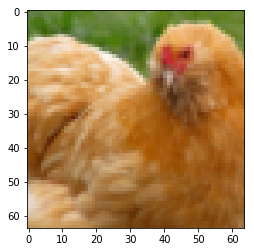

In [347]:
if matplotlib.get_backend().lower() != 'agg':
    im, lab = train_dataset[11000]
    im = im.permute(1,2,0).numpy()
    im = im - im.min()
    im = im / im.max()
    pyplot.imshow(im)

## Training

Training promises to take 60 hours on my computer.

In [ ]:
time1 = time.time()
for it_nr in range(num_iterations):
    opt_dis.param_groups[0]['lr'] = init_lr * (1 - max(it_nr - iterations_decay_start, 0) / (num_iterations - iterations_decay_start))
    opt_gen.param_groups[0]['lr'] = init_lr * (1 - max(it_nr - iterations_decay_start, 0) / (num_iterations - iterations_decay_start))
    for i in range(num_discriminator_iter):
        if i == 0:
            discriminator.eval() # ?
            for p in discriminator.parameters():
                p.requires_grad = False
            generator.train()
            for p in generator.parameters():
                p.requires_grad = True
            # generator step batch size could be made different from batch size
            y_fake = torch.randint(0, generator.n_classes, (batchsize,), device=device, dtype=torch.long)
            x_fake = generator(batchsize, y=y_fake)
            dis_fake = discriminator(x_fake, y=y_fake)
            loss_gen = -dis_fake.mean()
            opt_gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

        discriminator.train() # ?
        for p in discriminator.parameters():
            p.requires_grad = True
        generator.eval()
        for p in generator.parameters():
            p.requires_grad = False

        x_real, y_real = next(train_dl)
        x_real = x_real.to(device)
        y_real = y_real.to(device)
        bs = len(x_real)
        dis_real = discriminator(x_real, y=y_real)
        with torch.no_grad():
            y_fake = torch.randint(0, generator.n_classes, (bs,), device=device, dtype=torch.long)
            x_fake = generator(bs, y=y_fake).detach()
        dis_fake = discriminator(x_fake, y=y_fake)

        loss_dis = (torch.nn.functional.relu(1. - dis_real).mean() +
                    torch.nn.functional.relu(1. + dis_fake).mean())
        opt_dis.zero_grad()
        loss_dis.backward()
        opt_dis.step()
    if it_nr % 20 == 0:
        print('loss_gen', loss_gen.item())
        print('it_nr',it_nr, 'i', i, 'loss_dis', loss_dis.item())
        time2 = time.time()
        print ("it_nr", it_nr, "/", num_iterations, time2 - time1)
        remaining = int((time2 - time1)* (num_iterations - it_nr)/20.0)
        print ("remaining {:02d}:{:02d}:{:02d}".format(remaining//3600, remaining//60%60, remaining%60))
        time1 = time2
    if it_nr % 1000 == 0:
        with torch.no_grad():
            y_fake = torch.randint(0, generator.n_classes, (batchsize,), device=device, dtype=torch.long)
            x_fake = generator(batchsize, y=y_fake)

            imgs = x_fake.detach().view(8,8,3,64,64).permute(0,3,1,4,2).reshape(8*64,8*64,3)
            imgs = imgs - imgs.min()
            imgs = imgs / imgs.max()
            pyplot.figure(figsize=(10,10))
            pyplot.imshow(imgs.cpu().numpy())
            pyplot.savefig(f"sample_{it_nr}.jpg")
    if it_nr % 10000 == 0:
        print ("saving snapshot")
        torch.save([discriminator.state_dict(), generator.state_dict()], f"snapshot_{it_nr}.pt")
print ("saving snapshot")
torch.save([discriminator.state_dict(), generator.state_dict()], f"snapshot_{it_nr}.pt")


In [350]:
if matplotlib.get_backend().lower() == 'agg': # below is not for non-interactive
    import sys
    sys.exit(0)

## Sampling from a snapshot

In [31]:

[dis_sd, gen_sd] = torch.load('./snapshot_{it_nr}.pt')
discriminator.load_state_dict(dis_sd)
generator.load_state_dict(gen_sd)

In [ ]:
y_fake = torch.randint(0, generator.n_classes, (batchsize,), device=device, dtype=torch.long)
x_fake = generator(batchsize, y=y_fake)

imgs = x_fake.detach().view(8,8,3,64,64).permute(0,3,1,4,2).reshape(8*64,8*64,3)
imgs = imgs - imgs.min()
imgs = imgs / imgs.max()
%matplotlib inline
pyplot.figure(figsize=(10,10))
pyplot.imshow(imgs.cpu().numpy())
pyplot.savefig('sample_manual.jpg')

## Using the authors' pretrained model

I put the original decoding here, I don't think it dramatically changes the outputs relative to mapping from [min,max] to [0,1].

In [10]:
generator = ResNetGenerator(n_classes=143)
generator.eval()
import numpy
sd = numpy.load('/home/tv/data/paper-implementations/sngan_projection/pretrained/ResNetGeneratorImageNet_250000.npz')
k0 = sorted(sd.keys())
k2=sorted(generator.state_dict().keys())
k1 = [((k+'$').replace('/','.').replace('.beta','.bias').replace('.gamma','.weight')
           .replace('.avg_mean','.running_mean').replace('.avg_var','.running_var')
           .replace('.N$','.num_batches_tracked$').replace('.weights.W$','.weight$')
           .replace('.biass.W$','.bias$').replace('.W$','.weight$').replace('.b$','.bias$')
          [:-1],k) for k in k0]
sd2 = {k:torch.from_numpy(sd[kold]) for k,kold in k1}
generator.load_state_dict(sd2)


In [12]:
with torch.no_grad():
    res = generator(batchsize=25)

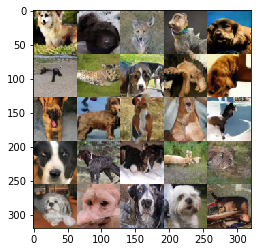

In [16]:
pyplot.imshow(((res.view(5,5,3,64,64).permute(0,3,1,4,2).reshape(5*64,5*64,3)*127.5+127.5).clamp(0,255).byte()).detach().numpy())